In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import scipy.stats
import numpy as np
from scipy.stats import truncnorm
from scipy.stats import multivariate_normal
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
from scipy.stats import norm

In [26]:
N = 10_000
s_1 = np.zeros(N)
s_2 = np.zeros(N)
sig_t = 5
A = np.array([[1, -1]])
t = np.zeros(N)
sigma_s = np.array([[100, 0], [0, 100]]) 
mu_matrix = np.array([100, 100]) 

s_1[0] = 100
s_2[0] = 100
t[0] = 20


In [116]:
def gibbs_sample(N, mu_s1, var_s1, mu_s2, var_s2, t_param, var_t, y):

    s_1 = np.zeros(N)
    s_2 = np.zeros(N)
    t = np.zeros(N)


    sigma_s = np.array([[var_s1, 0], [0, var_s2]]) 
    mu_matrix = np.array([mu_s1, mu_s2]) 

    s_1[0] = mu_s1
    s_2[0] = mu_s2
    t[0] = t_param


    sig_t = var_t
    A = np.array([[1, -1]])


    # y = 1
    y = y
    a, b = 0, np.inf

    # mu_t = s_1[0]-s_2[0]

    # do heavy calculations before loop
    sigma_st = np.linalg.inv(np.linalg.inv(sigma_s) + A.transpose()*(sig_t**(-1))*A)

    A_t__inv_sig_t = A.transpose()*(sig_t**(-1))
    matmul_inv_sig_s_mu_mat = np.matmul(np.linalg.inv(sigma_s),mu_matrix)

    mu_t = s_1[0]-s_2[0] # to calc mu_t before game with anterior skills
    for n in range(N-1):
        # mu_t = s_1[n]-s_2[n] #calc mu_t with posterior skills

        if y == 1: # between 0 and inf
            t[n+1] = truncnorm.rvs(a, b, loc=mu_t, scale=sig_t, size=1)
        else: # between -inf and 0
            t[n+1] = truncnorm.rvs(-b, a, loc=mu_t, scale=sig_t, size=1)
        
        mu_st = np.matmul(sigma_st,(matmul_inv_sig_s_mu_mat + A_t__inv_sig_t*t[n+1]))
        new_s = np.random.multivariate_normal([mu_st[0][0], mu_st[1][0]], sigma_st)
        s_1[n+1] = new_s[0]
        s_2[n+1] = new_s[1]

    return(s_1, s_2, t)

In [103]:
iter = 10000
s1, s2, t = gibbs_sample(iter, 100, 20, 100, 20, 0, 20)

Text(0.5, 1.0, 't dist')

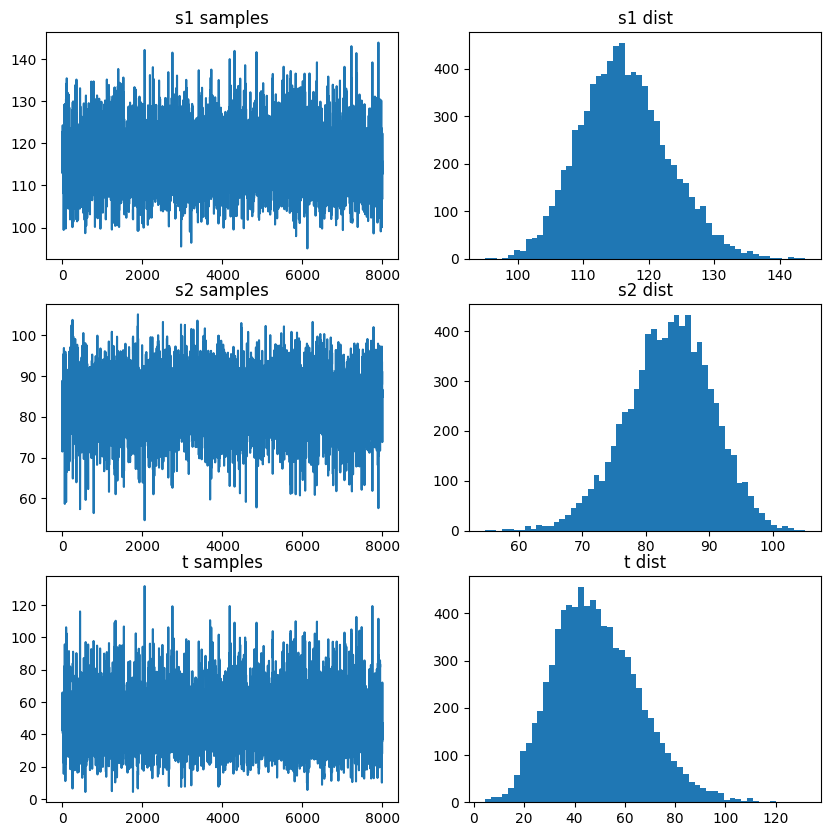

In [104]:
burnin = 2000

iterations_num = [i + 1 for i in range(iter-burnin)]

plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(3, 2)

axs[0, 0].plot(iterations_num,s1[burnin:])
axs[0, 0].set_title("s1 samples")
axs[0, 1].hist(s1[burnin:],bins = "auto")
axs[0, 1].set_title("s1 dist")
axs[1, 0].plot(iterations_num,s2[burnin:])
axs[1, 0].set_title("s2 samples")
axs[1, 1].hist(s2[burnin:],bins = "auto")
axs[1, 1].set_title("s2 dist")
axs[2, 0].plot(iterations_num,t[burnin:])
axs[2, 0].set_title("t samples")
axs[2, 1].hist(t[burnin:],bins = "auto")
axs[2, 1].set_title("t dist")



# plt.plot(iterations_num,s1[burnin:])
# plt.show()
# plt.hist(s1[burnin:],bins = "auto")
# plt.show()
# plt.plot(iterations_num,s2[burnin:])
# plt.show()
# plt.hist(s2[burnin:],bins = "auto")
# plt.show()
# plt.plot(iterations_num,t[burnin:])
# plt.show()
# plt.hist(t[burnin:],bins = "auto")
# plt.show()

In [109]:
# READ DATA FILE
data = pd.read_csv("SerieA.csv", delimiter=",")
print(data)

     yyyy-mm-dd  HH:MM       team1     team2  score1  score2
0    2018-08-18  18:00      Chievo  Juventus       2       3
1    2018-08-18  20:30       Lazio    Napoli       1       2
2    2018-08-19  18:00      Torino      Roma       0       1
3    2018-08-19  20:30    Sassuolo     Inter       1       0
4    2018-08-19  20:30       Parma   Udinese       2       2
..          ...    ...         ...       ...     ...     ...
375  2019-05-26  20:30        Roma     Parma       2       1
376  2019-05-26  20:30       Inter    Empoli       2       1
377  2019-05-26  20:30  Fiorentina     Genoa       0       0
378  2019-05-26  20:30    Cagliari   Udinese       1       2
379  2019-05-26  20:30    Atalanta  Sassuolo       3       1

[380 rows x 6 columns]


In [117]:
# MODIFY DATA

#all teams in serie a
teams = data["team1"].unique()

#initial skill ?
init_s = 10
init_var = 1

#assign skill and var
team_skills = {}
for team in teams:
    #team_skills = {teamname : [mean, var]}
    team_skills[team] = [init_s, init_var] 



In [118]:
# GIBBS SAMPLE EVERY MATCH

for index, match in data.iterrows():
    # identify teams
    team1 = match['team1']
    team2 = match['team2']
    print(f"{round(100*(index+1)/380,2)}%, {team1} vs {team2}: ")

    #ignore draws
    if(match["score1"] == match["score2"]):
        print("Draw")
        continue

    # find current team values
    mu_s1, mu_s2 = team_skills[team1][0], team_skills[team2][0]
    var_s1, var_s2 = team_skills[team1][1], team_skills[team2][1]

    #number of iterations in gibbs sampling
    iter = 1000

    #check what team won
    if(match["score1"] > match["score2"]):
        y = 1
        print(f"Winner: {team1}")
    else:
        y = -1
        print(f"Winner: {team2}")

    # call sample func
    s1, s2, t = gibbs_sample(iter, mu_s1, var_s1, mu_s2, var_s2, 0, 20, y)

    #calc new mean and var
    new_mu_s1 = np.mean(s1)
    new_mu_s2 = np.mean(s2)

    new_var_s1 = np.var(s1)
    new_var_s2 = np.var(s2)

    team_skills[team1] = [new_mu_s1, new_var_s1]
    team_skills[team2] = [new_mu_s2, new_var_s2]


0.26%, Chievo vs Juventus: 
Winner: Juventus
0.53%, Lazio vs Napoli: 
Winner: Napoli
0.79%, Torino vs Roma: 
Winner: Roma
1.05%, Sassuolo vs Inter: 
Winner: Sassuolo
1.32%, Parma vs Udinese: 
Draw
1.58%, Empoli vs Cagliari: 
Winner: Empoli
1.84%, Bologna vs Spal: 
Winner: Spal
2.11%, Atalanta vs Frosinone: 
Winner: Atalanta
2.37%, Juventus vs Lazio: 
Winner: Juventus
2.63%, Napoli vs Milan: 
Winner: Napoli
2.89%, Spal vs Parma: 
Winner: Spal
3.16%, Udinese vs Sampdoria: 
Winner: Udinese
3.42%, Inter vs Torino: 
Draw
3.68%, Genoa vs Empoli: 
Winner: Genoa
3.95%, Frosinone vs Bologna: 
Draw
4.21%, Fiorentina vs Chievo: 
Winner: Fiorentina
4.47%, Cagliari vs Sassuolo: 
Draw
4.74%, Roma vs Atalanta: 
Draw
5.0%, Milan vs Roma: 
Winner: Milan
5.26%, Bologna vs Inter: 
Winner: Inter
5.53%, Parma vs Juventus: 
Winner: Juventus
5.79%, Fiorentina vs Udinese: 
Winner: Fiorentina
6.05%, Torino vs Spal: 
Winner: Torino
6.32%, Sassuolo vs Genoa: 
Winner: Sassuolo
6.58%, Sampdoria vs Napoli: 
Winner:

In [115]:
print(team_skills)

{'Chievo': [45908.9145132253, 22557361.608171344], 'Lazio': [121591.74308987406, 29177934.126634616], 'Torino': [377078.08665806684, 35484863.53915977], 'Sassuolo': [143647.84837454796, 27606190.688199334], 'Parma': [35640.86616315935, 22882128.71047464], 'Empoli': [-82452.38423728338, 25932041.627050642], 'Bologna': [-19768.496590965206, 12560611.382313125], 'Atalanta': [227348.31699801685, 20243186.88429976], 'Juventus': [135157.7435458158, 23501703.252684943], 'Napoli': [33057.645443468304, 16501566.371444331], 'Spal': [-93457.25758692285, 26339549.103289664], 'Udinese': [24215.73603155942, 72811248.86862463], 'Inter': [94555.32079911453, 20887495.044611968], 'Genoa': [-92408.28125281629, 29642184.24561645], 'Frosinone': [425905.9404430499, 27118117.822149277], 'Fiorentina': [-0.38617279789752534, 96.76685270244788], 'Cagliari': [-428162.41608774127, 73830853.78688839], 'Roma': [209717.2422685656, 28641854.344123185], 'Milan': [27792.503668561338, 19103139.576468594], 'Sampdoria': [